<a href="https://colab.research.google.com/github/Kyriezxc/CIS522_Project/blob/Zhiyu_experiments/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/Colab Notebooks/CIS522_Project"

/content/drive/MyDrive/Colab Notebooks/CIS522_Project


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train = pd.read_csv("data/train.csv")

In [4]:
# Filter missing data and useless columns
train = train[train["MISSING_DATA"] == False]
train = train[train["POLYLINE"].map(len) > 1]
train = train[train["POLYLINE"] != "[]"]
train = train[["POLYLINE"]]
# Choose 10000 rows randomly from dataset to run
train_1 = train.sample(10000, random_state=2023)

train_1

,POLYLINE
673744,"[[-8.612595,41.146191],[-8.611551,41.146119],[..."
1541850,"[[-8.628831,41.160978],[-8.628831,41.160987],[..."
1547523,"[[-8.613225,41.166801],[-8.613324,41.166684],[..."
775649,"[[-8.569674,41.160771],[-8.569665,41.160897],[..."
1384848,"[[-8.56656,41.153265],[-8.566524,41.153292],[-..."
...,...
899301,"[[-8.627877,41.14467],[-8.629929,41.145093],[-..."
1010655,"[[-8.608887,41.147487],[-8.608185,41.147784],[..."
1665872,"[[-8.608707,41.147802],[-8.608527,41.147766],[..."
712884,"[[-8.614125,41.146209],[-8.614107,41.146218],[..."


# Pre-processing

In [5]:
def _change_type(polyline):
    polyline = polyline[2:-2]
    cords_raw = polyline.split("],[")
    cords = []
    max_lon, min_lon, max_lat, min_lat = float("-inf"), float("inf"), float("-inf"), float("inf")
    for cord in cords_raw:
        cords.append([float(loc) for loc in cord.split(",")])
        max_lon = max(max_lon, cords[-1][0])
        min_lon = min(min_lon, cords[-1][0])
        max_lat = max(max_lat, cords[-1][1])
        min_lat = min(min_lat, cords[-1][1])
    return pd.Series({"POLYLINE": cords, "max_lon": max_lon, "min_lon": min_lon, "max_lat": max_lat, "min_lat": min_lat})

In [6]:
def filter_map(train, max_lat, min_lat, max_lon, min_lon):
    train.reset_index(drop=True, inplace=True)
    return train[(train["max_lat"] <= max_lat) & (train["min_lat"] >= min_lat) &
                 (train["max_lon"] <= max_lon) & (train["min_lon"] >= min_lon)]

In [7]:
def _normalize(polyline, max_lon, min_lon, max_lat, min_lat):
    final = [[(cord[0]-min_lon)/(max_lon-min_lon), (cord[1] - min_lat) / (max_lat - min_lat)] for cord in polyline]
    return pd.Series({"POLYLINE_INIT": final[:-1], "POLYLINE_DEST": final[-1]})

In [8]:
def _to_matrix(polyline, m):
    mat = np.zeros((m, m))
    n = len(polyline)
    for i in range(n):
        x = min(m - 1, int(polyline[i][0] * m))
        y = min(m - 1, int(polyline[i][1] * m))
        mat[y][x] = (i + 1) / n
    return mat

In [9]:
def transform(df_train, m):
    # Change type
    changed = df_train["POLYLINE"].apply(_change_type)
    # Filter map for max/min long/lat
    changed = filter_map(changed, 41.2, 41, -8.6, -8.7)
    # Get min-max
    max_longitude = changed["max_lon"].max()
    min_longitude = changed["min_lon"].min()
    max_latitude = changed["max_lat"].max()
    min_latitude = changed["min_lat"].min()
    # Normalize min-max and split
    cleaned = changed["POLYLINE"].apply(_normalize, args=(max_longitude, min_longitude, max_latitude, min_latitude))
    # Transform to matrices
    cleaned["MATRIX"] = cleaned["POLYLINE_INIT"].apply(_to_matrix, args=(m,))
    return cleaned

In [10]:
transformed = transform(train_1, 256)
len(transformed)

5809

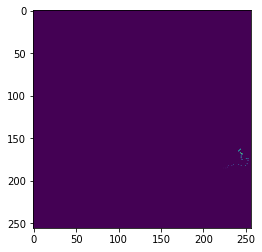

In [11]:
mat = transformed["MATRIX"].iloc[0]

plt.imshow(mat)
plt.show()

In [12]:
transformed.head()

,POLYLINE_INIT,POLYLINE_DEST,MATRIX
0,"[[0.8742342342342228, 0.7259990813045455], [0....","[0.9612612612612519, 0.6409738171795833]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,"[[0.7117117117117076, 0.8014699127239199], [0....","[0.6336036036035904, 0.7591180523656118]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,"[[0.8679279279279241, 0.831189710610917], [0.8...","[0.8209009009009027, 0.7312356453835327]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,"[[0.5051351351351239, 0.7669269637115131], [0....","[0.824144144144137, 0.7284795590261557]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,"[[0.27891891891891146, 0.9078548461184808], [0...","[0.7655855855855725, 0.8426734037666541]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


# Model Experiments

In [13]:
def sequence2tensor(sequence, seqlen=200):
    if len(sequence) > seqlen:
        sequence = sequence[-seqlen:]
    tensor = torch.zeros(seqlen, 3)
    for i, point in enumerate(sequence, start=seqlen-len(sequence)):
        tensor[i, :2] = torch.Tensor(point)
        tensor[i, 2] = 1  # 1 for in the sequence, 0 for out of the sequence
    return tensor

def matrix2tensor(matrix):
    return torch.Tensor(matrix)

def output2tensor(output):
    return torch.Tensor(output)

In [14]:
sequence_tensor = transformed["POLYLINE_INIT"].apply(sequence2tensor).values
matrix_tensor = transformed["MATRIX"].apply(matrix2tensor).values
output_tensor = transformed["POLYLINE_DEST"].apply(output2tensor).values

In [15]:
sequence_tensor[0]

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.000

In [16]:
matrix_tensor[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [17]:
output_tensor[0]

tensor([0.9613, 0.6410])

In [18]:
seq_train, seq_valid, mat_train, mat_valid, out_train, out_valid = \
train_test_split(sequence_tensor, matrix_tensor, output_tensor, test_size=0.2, random_state=2023)

## Simple RNN

In [19]:
class SequenceDataset(Dataset):
    def __init__(self, sequence, output):
        self.sequence = sequence
        self.output = output

    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, idx):
        return self.sequence[idx], self.output[idx]

In [20]:
train_data = SequenceDataset(seq_train, out_train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

valid_data = SequenceDataset(seq_valid, out_valid)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)

In [21]:
class RNN(nn.Module):
    def __init__(self, i_size=3, h_size=6, n_layers=1, o_size=2, activation="relu"):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size = i_size,
            hidden_size = h_size,
            num_layers = n_layers,
            nonlinearity = activation,
            batch_first = True
        )
        self.out = nn.Linear(h_size, o_size)
        
    def forward(self, x):
        out, h = self.rnn(x, None)  # None represents zero initial hidden state
        return torch.sigmoid(self.out(out[:, -1, :]))  # choose last time step of output

  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.28379642942996874
Validation loss: 0.24534312125883603


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.19349425969875023
Validation loss: 0.1418727761820743


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.1349824156663189
Validation loss: 0.12569570266886762


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.1227847330578386
Validation loss: 0.11731798946857452


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.11664869575059578
Validation loss: 0.11294806356492795


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.10748626587733831
Validation loss: 0.10153851226756447


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.10045222458365845
Validation loss: 0.09950585506464306


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.09730003519009238
Validation loss: 0.09568021407252864


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.09467610563725641
Validation loss: 0.09206819730369668


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.09165862202644348
Validation loss: 0.08867495271720384


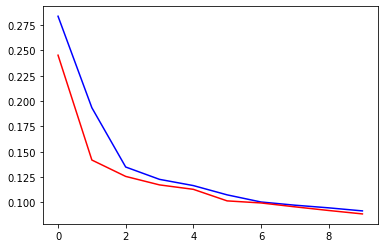

In [22]:
learning_rate = 0.001
rnn = RNN(3, 6, 1, 2)
rnn.to(device)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.L1Loss()

train_losses, valid_losses = [], []
for epoch in range(10):
    rnn.train()
    train_loss = []
    for seq, out in tqdm(train_loader):
        seq, out = seq.to(device), out.to(device)
        optimizer.zero_grad()
        pred = rnn(seq)
        loss = criterion(pred, out)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_losses.append(np.mean(train_loss))
    print("Train loss: {}".format(train_losses[-1]))
    rnn.eval()
    valid_loss = []
    for seq, out in valid_loader:
        seq, out = seq.to(device), out.to(device)
        pred = rnn(seq)
        loss = criterion(pred, out)
        valid_loss.append(loss.item())
    valid_losses.append(np.mean(valid_loss))
    print("Validation loss: {}".format(valid_losses[-1]))

plt.figure()
plt.plot(train_losses, color="blue")
plt.plot(valid_losses, color="red")
plt.show()

## MLP with matrix input

In [23]:
class MatrixDataset(Dataset):
    def __init__(self, matrix, output):
        self.matrix = matrix
        self.output = output

    def __len__(self):
        return len(self.matrix)

    def __getitem__(self, idx):
        return self.matrix[idx], self.output[idx]

In [24]:
train_data = MatrixDataset(mat_train, out_train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

valid_data = MatrixDataset(mat_valid, out_valid)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)

In [25]:
class MLP(nn.Module):
    def __init__(self, i_size=256*256, h_size=100, h_layers=2, o_size=2):
        super(MLP, self).__init__()
        self.hiddens = nn.Sequential()
        for i in range(h_layers):
            if i == 0:
                hidden = nn.Sequential(nn.Linear(i_size, h_size), nn.Dropout(), nn.ReLU())
            else:
                hidden = nn.Sequential(nn.Linear(h_size, h_size), nn.Dropout(), nn.ReLU())
            self.hiddens.append(hidden)
        self.out = nn.Linear(h_size, o_size)
        
    def forward(self, x):
        x = x.flatten(1)
        for hidden in self.hiddens:
            x = hidden(x)
        return torch.sigmoid(self.out(x))

  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.16016073800521355
Validation loss: 0.06775270010295667


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.07151651168114519
Validation loss: 0.04652517484991174


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.059186710172320064
Validation loss: 0.04199376957196938


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0535490070916202
Validation loss: 0.040432661967842204


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.05046287449459507
Validation loss: 0.039897603325937926


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04736292454069608
Validation loss: 0.03655825888640002


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04542962936301754
Validation loss: 0.0362595989319839


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04439431357465378
Validation loss: 0.036563224502299964


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04258659686127754
Validation loss: 0.036024753004312515


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.041860159843751826
Validation loss: 0.03561677695497086


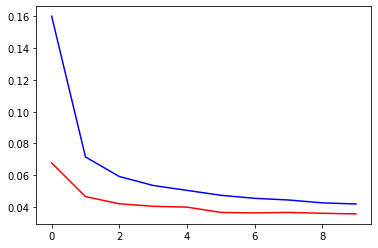

In [26]:
learning_rate = 0.001
mlp = MLP()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)
criterion = nn.L1Loss()

train_losses, valid_losses = [], []
for epoch in range(10):
    mlp.train()
    train_loss = []
    for mat, out in tqdm(train_loader):
        mat, out = mat.to(device), out.to(device)
        optimizer.zero_grad()
        pred = mlp(mat)
        loss = criterion(pred, out)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_losses.append(np.mean(train_loss))
    print("Train loss: {}".format(train_losses[-1]))
    mlp.eval()
    valid_loss = []
    for mat, out in valid_loader:
        mat, out = mat.to(device), out.to(device)
        pred = mlp(mat)
        loss = criterion(pred, out)
        valid_loss.append(loss.item())
    valid_losses.append(np.mean(valid_loss))
    print("Validation loss: {}".format(valid_losses[-1]))

plt.figure()
plt.plot(train_losses, color="blue")
plt.plot(valid_losses, color="red")
plt.show()